In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random

In [3]:
random.seed(760)

In [4]:
data=pd.read_csv('drive/MyDrive/clean_data.csv', encoding='utf-8')

In [5]:
def get_season(month): #spring0summer1autumn2winter3
    if 9 <= month <= 11:
        return "0"
    elif 12 <= month <= 2:
        return "1"
    elif 3 <= month <= 6:
        return "2"
    else:
        return "3"
data['Date'] = pd.to_datetime(data['Date'])
data['season'] = data['Date'].dt.month.apply(get_season)
grouped_data = data.groupby("Date")["Victimisations"].sum().reset_index()
grouped_data['season'] = data.groupby("Date")['season'].first().reset_index()['season']

In [6]:
train_data = grouped_data[grouped_data['Date'] < '2021-01-01']
test_data = grouped_data[grouped_data['Date'] >= '2021-01-01']

In [7]:
scaler = MinMaxScaler()
grouped_data_scaled = scaler.fit_transform(grouped_data[['Victimisations', 'season']])
train_data_scaled = grouped_data_scaled[grouped_data['Date'] < '2021-01-01']
test_data_scaled = grouped_data_scaled[grouped_data['Date'] >= '2021-01-01']

In [8]:
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 3
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

In [34]:
### only LSTM
model = Sequential()
model.add(LSTM(150,return_sequences=True,input_shape=(window_size, 2)))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train, y_train, epochs=200, batch_size=4,validation_split=0.15,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 9s 112ms/step - loss: 0.0876 - val_loss: 0.1065
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0188 - val_loss: 0.0464
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0583
Epoch 4/200
14/14 [==============================] - 0s 14ms/step - loss: 0.0047 - val_loss: 0.0507
Epoch 5/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0478
Epoch 6/200
14/14 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0486
Epoch 7/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0035 - val_loss: 0.0567
Epoch 8/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0526
Epoch 9/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0484
Epoch 10/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.057

In [35]:
predicted = model.predict(X_test)
predicted_transformed = scaler.inverse_transform(np.concatenate([np.reshape(predicted, (-1, 1)), np.zeros((len(predicted), 1))], axis=1))[:, 0]
y_test_transformed = scaler.inverse_transform(np.concatenate([np.reshape(y_test, (-1, 1)), np.zeros((len(y_test), 1))], axis=1))[:, 0]

1/1 [==============================] - 1s 1s/step


In [36]:
predicted_train = model.predict(X_train)
predicted_train_transformed = scaler.inverse_transform(np.concatenate([np.reshape(predicted_train, (-1, 1)), np.zeros((len(predicted_train), 1))], axis=1))[:, 0]
y_train_transformed = scaler.inverse_transform(np.concatenate([np.reshape(y_train, (-1, 1)), np.zeros((len(y_train), 1))], axis=1))[:, 0]

3/3 [==============================] - 0s 9ms/step


3/3 [==============================] - 0s 9ms/step


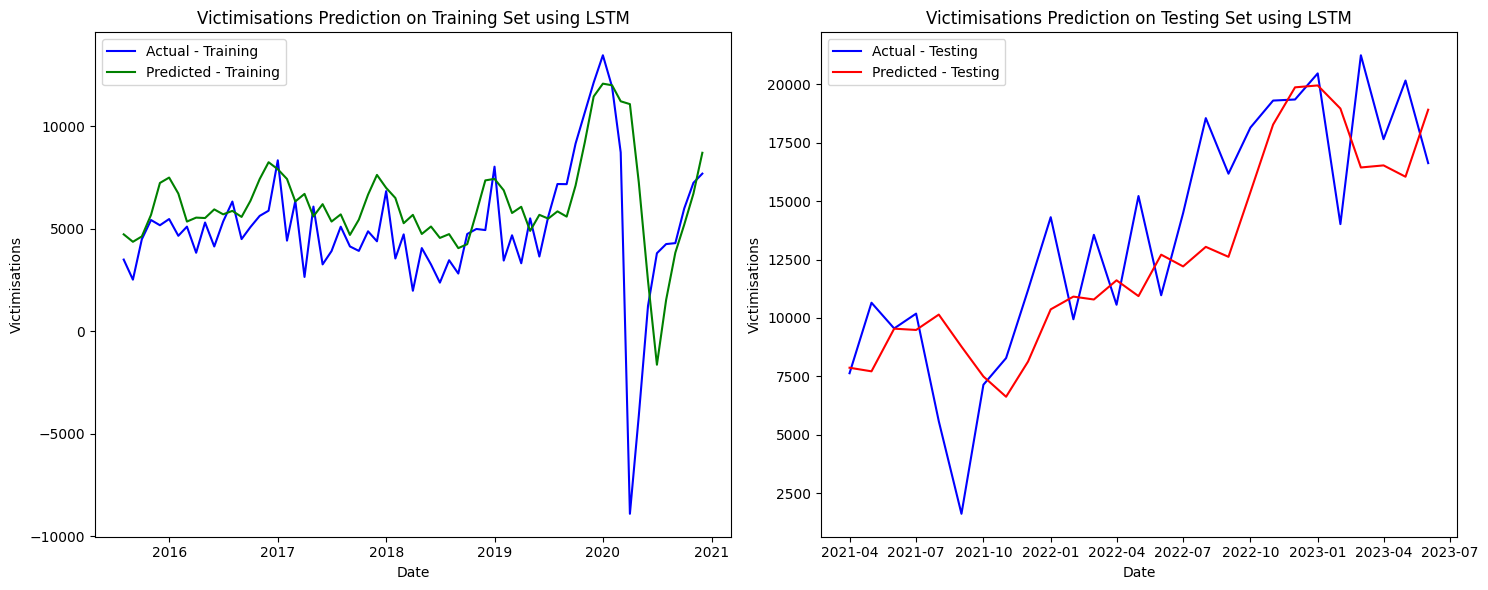

In [37]:
train_time_axis = train_data['Date'].values[window_size:]
test_time_axis = test_data['Date'].values[window_size:]
predicted_train = model.predict(X_train)
predicted_train_transformed = scaler.inverse_transform(np.concatenate([np.reshape(predicted_train, (-1, 1)), np.zeros((len(predicted_train), 1))], axis=1))[:, 0]
y_train_transformed = scaler.inverse_transform(np.concatenate([np.reshape(y_train, (-1, 1)), np.zeros((len(y_train), 1))], axis=1))[:, 0]
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(train_time_axis, y_train_transformed, label='Actual - Training', color='blue')
plt.plot(train_time_axis, predicted_train_transformed, label='Predicted - Training', color='green')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction on Training Set using LSTM')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_time_axis, y_test_transformed, label='Actual - Testing', color='blue')
plt.plot(test_time_axis, predicted_transformed, label='Predicted - Testing', color='red')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction on Testing Set using LSTM')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
test_mse = mean_squared_error(y_test_transformed, predicted_transformed)
print(f"测试集的MSE: {test_mse}")
train_mse = mean_squared_error(y_train_transformed, predicted_train_transformed)
print(f"训练集的MSE: {train_mse}")

测试集的MSE: 8354072.056012581
训练集的MSE: 4784682.9682358075


In [14]:
future_months = 6
future_predictions = np.zeros((future_months, 2))
last_window = test_data_scaled[-window_size:].reshape(1, window_size, 2)
last_window = last_window.astype('float32')
current_month = 6
current_year = 2023

In [15]:
for i in range(future_months):
    next_prediction = model.predict(last_window)
    future_predictions[i, 0] = next_prediction
    current_month += 1
    if current_month > 12:
        current_month = 1

    next_season = get_season(current_month)
    new_row_scaled = scaler.transform(np.array([[0, next_season]]))
    new_row = np.array([[next_prediction[0, 0], new_row_scaled[0, 1]]])
    last_window = np.append(last_window[:, 1:, :], new_row.reshape(1, 1, 2), axis=1)
future_predictions_transformed = scaler.inverse_transform(future_predictions)[:, 0]

1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


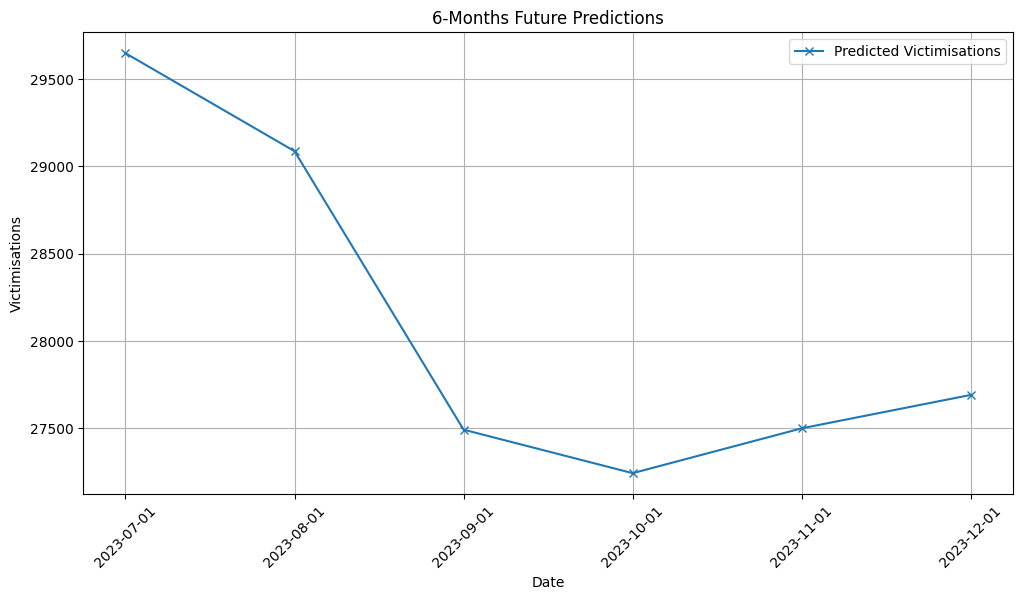

In [16]:
test_dates = [f"2023-{str(month).zfill(2)}-01" for month in range(1, 7)]
future_dates = [f"2023-{str(month).zfill(2)}-01" for month in range(7, 13)]
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_transformed, marker='x', label='Predicted Victimisations')
plt.title('6-Months Future Predictions')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [17]:
### ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

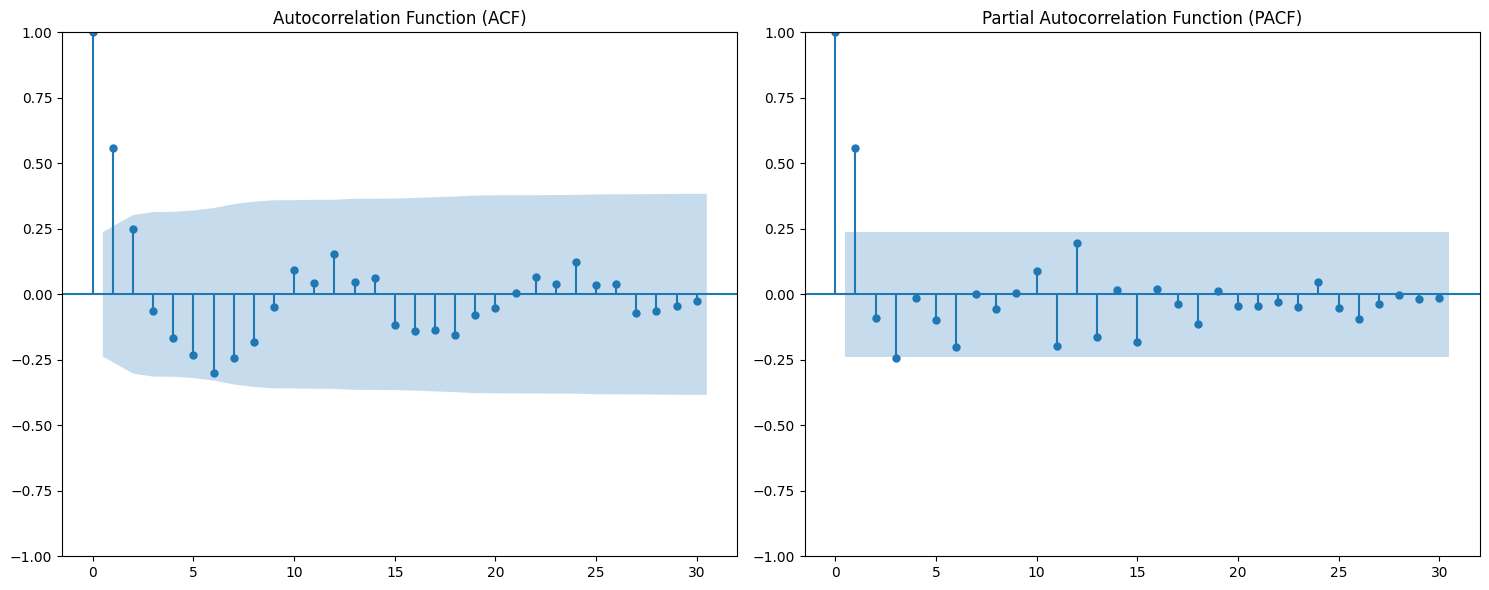

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(train_data['Victimisations'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(train_data['Victimisations'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [19]:
model = SARIMAX(train_data['Victimisations'], order=(1,0,2), seasonal_order=(1,0,1,12))
model_fit = model.fit()
predictions_ARIMA = model_fit.forecast(steps=len(test_data))
fitted_values = model_fit.fittedvalues
actual_values = train_data['Victimisations']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [20]:
predictions_ARIMA = model_fit.forecast(steps=len(test_data))
actual_values_test = test_data['Victimisations']
mse_train = mean_squared_error(actual_values, fitted_values)
mse_test = mean_squared_error(actual_values_test, predictions_ARIMA)

In [21]:
mse_test

48132602.052014

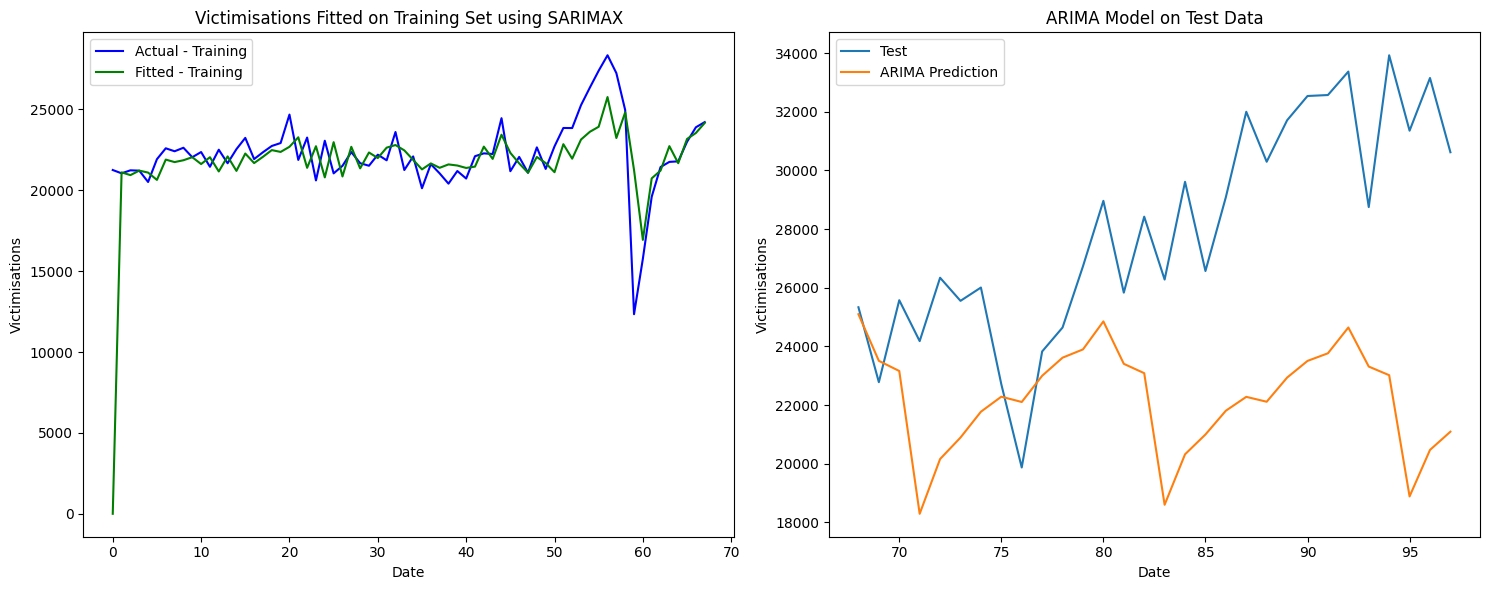

In [22]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(actual_values, label='Actual - Training', color='blue')
plt.plot(fitted_values, label='Fitted - Training', color='green')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Fitted on Training Set using SARIMAX')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_data.index, test_data['Victimisations'], label='Test')
plt.plot(test_data.index, predictions_ARIMA, label='ARIMA Prediction')
plt.title("ARIMA Model on Test Data")
plt.xlabel("Date")
plt.ylabel("Victimisations")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
###ARIMA+LSTM
residuals = train_data['Victimisations'] - model_fit.fittedvalues
scaler = MinMaxScaler()
residuals_with_season = pd.DataFrame({'residuals': residuals, 'season': train_data['season']})
residuals_with_season_scaled = scaler.fit_transform(residuals_with_season)
window_size = 3
X_train_res, y_train_res = create_dataset(residuals_with_season_scaled, window_size)
model_res = Sequential()
model_res.add(LSTM(200, return_sequences=True, input_shape=(window_size, 2)))
model_res.add(LSTM(150))
model_res.add(Dropout(0.1))
model_res.add(Dense(1))
model_res.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history_res = model_res.fit(X_train_res, y_train_res, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 15s 114ms/step - loss: 0.0305 - val_loss: 0.0247
Epoch 2/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0131
Epoch 3/200
14/14 [==============================] - 0s 20ms/step - loss: 0.0029 - val_loss: 0.0128
Epoch 4/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0023 - val_loss: 0.0125
Epoch 5/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0154
Epoch 6/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0121
Epoch 7/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 8/200
14/14 [==============================] - 0s 22ms/step - loss: 0.0019 - val_loss: 0.0131
Epoch 9/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0121
Epoch 10/200
14/14 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.01

In [39]:
predicted_res = model_res.predict(X_test)
zero_col = np.zeros((predicted_res.shape[0], 1))
predicted_res_with_zero_col = np.hstack([predicted_res, zero_col])
predicted_res_transformed = scaler.inverse_transform(predicted_res_with_zero_col)
predicted_res_transformed_1D = predicted_res_transformed[:, 0]
min_length = min(len(predictions_ARIMA), len(predicted_res_transformed_1D))
predicted_res_transformed = -predicted_res_transformed
final_prediction = predictions_ARIMA[:min_length] + predicted_res_transformed_1D[:min_length]

1/1 [==============================] - 1s 1s/step


In [40]:
predicted_res_train = model_res.predict(X_train_res)
zero_col_train = np.zeros((predicted_res_train.shape[0], 1))
predicted_res_with_zero_col_train = np.hstack([predicted_res_train, zero_col_train])
predicted_res_transformed_train = scaler.inverse_transform(predicted_res_with_zero_col_train)
predicted_res_transformed_1D_train = predicted_res_transformed_train[:, 0]
final_prediction_train = model_fit.fittedvalues[:len(predicted_res_transformed_1D_train)] + predicted_res_transformed_1D_train

3/3 [==============================] - 0s 8ms/step


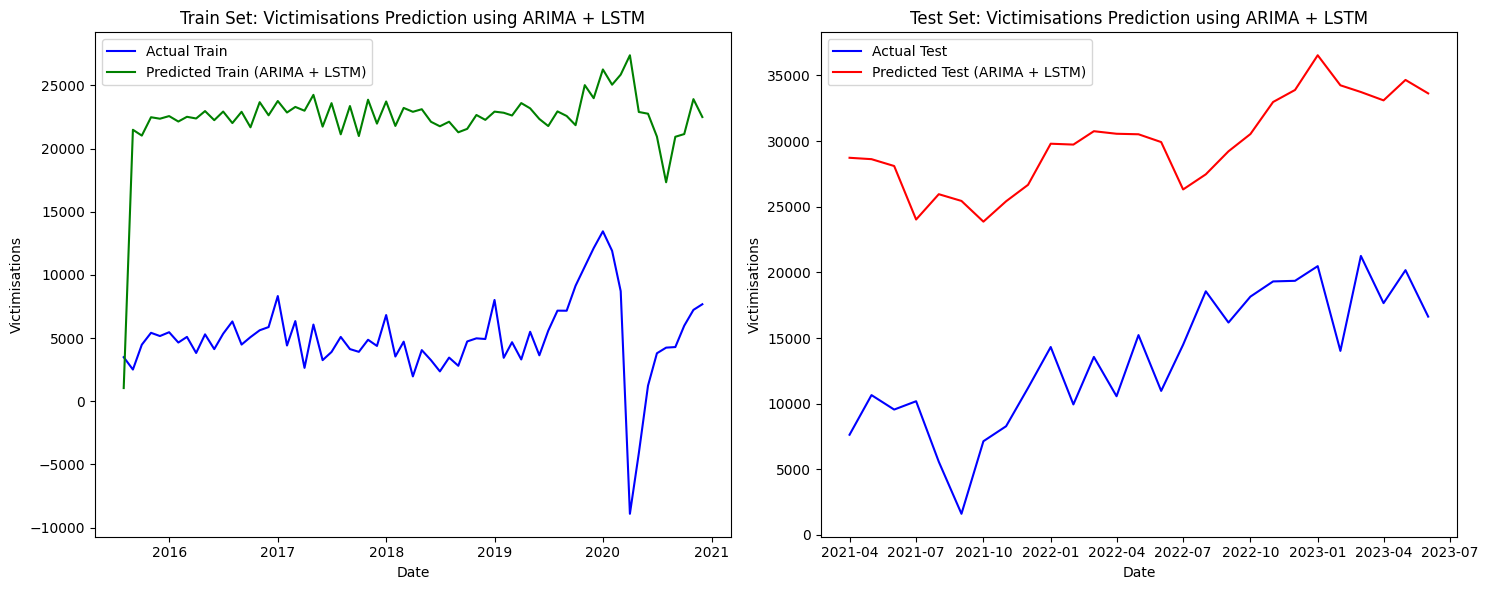

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(train_time_axis, y_train_transformed, label='Actual Train', color='blue')
axes[0].plot(train_time_axis, final_prediction_train, label='Predicted Train (ARIMA + LSTM)', color='green')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Victimisations')
axes[0].set_title('Train Set: Victimisations Prediction using ARIMA + LSTM')
axes[0].legend()
axes[1].plot(test_time_axis, y_test_transformed, label='Actual Test', color='blue')
axes[1].plot(test_time_axis, final_prediction, label='Predicted Test (ARIMA + LSTM)', color='red')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Victimisations')
axes[1].set_title('Test Set: Victimisations Prediction using ARIMA + LSTM')
axes[1].legend()
plt.tight_layout()
plt.show()

In [27]:
y_train_actual = train_data['Victimisations']
y_test_actual = test_data['Victimisations']
min_length_train = min(len(y_train_actual), len(final_prediction_train))
min_length_test = min(len(y_test_actual), len(final_prediction))
train_mse = mean_squared_error(y_train_actual[:min_length_train], final_prediction_train[:min_length_train])
print(f"训练集的MSE: {train_mse}")
test_mse = mean_squared_error(y_test_actual[:min_length_test], final_prediction[:min_length_test])
print(f"测试集的MSE: {test_mse}")

训练集的MSE: 8703286.085684387
测试集的MSE: 9890945.979031593


In [28]:
###ARIMA+ANN
residuals_with_season = pd.DataFrame({'residuals': residuals, 'season': train_data['season']})
scaler = MinMaxScaler()
residuals_with_season_scaled = scaler.fit_transform(residuals_with_season)

In [29]:
model_nn = Sequential()
model_nn.add(Dense(100, input_dim=2, activation='swish'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(50, activation='swish'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(1, activation='linear'))
model_nn.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_nn.fit(residuals_with_season_scaled[:-1], residuals[1:], epochs=100, batch_size=5, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/100
11/11 [==============================] - 1s 26ms/step - loss: 1044974.6875 - val_loss: 8963398.0000
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1044920.4375 - val_loss: 8963398.0000
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 1044873.1875 - val_loss: 8963399.0000
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1044830.8125 - val_loss: 8963401.0000
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1044768.2500 - val_loss: 8963399.0000
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 1044721.5625 - val_loss: 8963386.0000
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 1044645.3125 - val_loss: 8963381.0000
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 1044544.6250 - val_loss: 8963363.0000
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 1044530.9375 - val_loss: 8963357.0000


In [30]:
test_residuals = test_data['Victimisations'] - predictions_ARIMA
test_residuals_with_season = pd.DataFrame({'residuals': test_residuals, 'season': test_data['season']})
test_residuals_with_season_scaled = scaler.transform(test_residuals_with_season)
nn_predictions = model_nn.predict(test_residuals_with_season_scaled)
final_predictions = predictions_ARIMA + nn_predictions.flatten()

1/1 [==============================] - 0s 105ms/step


In [31]:
train_residuals_with_season_scaled = residuals_with_season_scaled
nn_train_predictions = model_nn.predict(train_residuals_with_season_scaled)
final_predictions_train = fitted_values + nn_train_predictions.flatten()

3/3 [==============================] - 0s 3ms/step


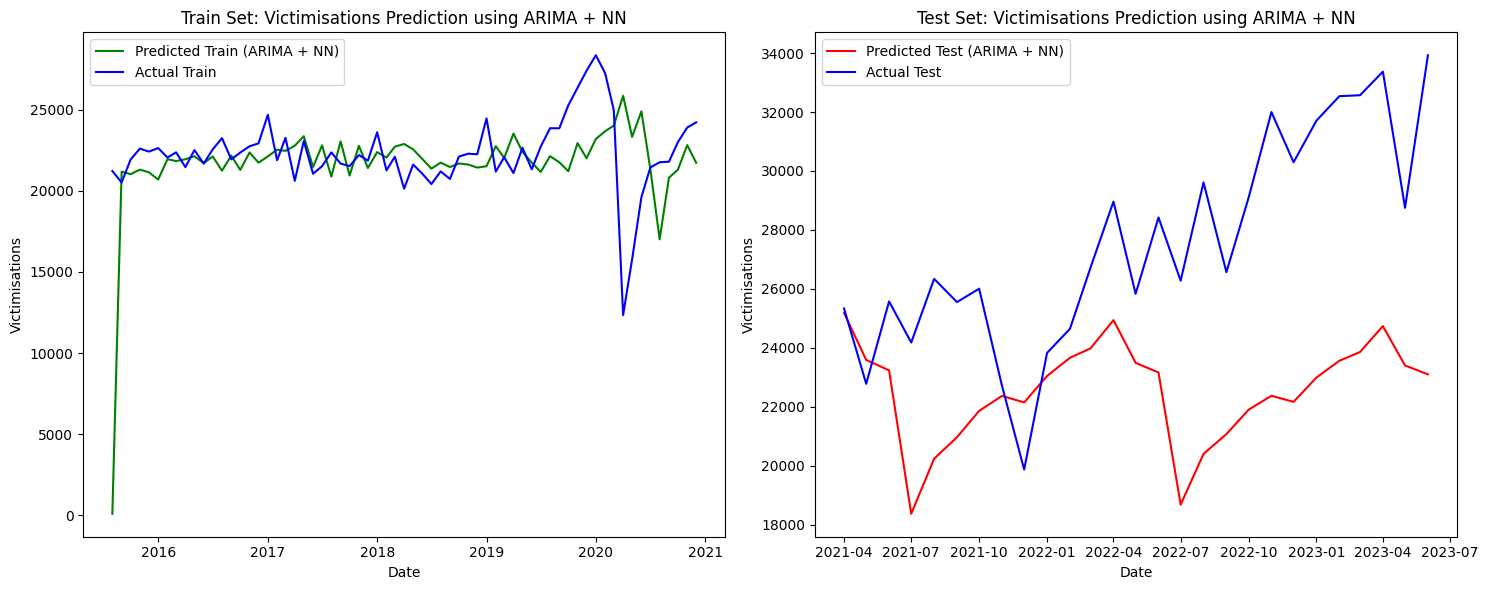

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
min_length_train = min(len(train_time_axis), len(final_predictions_train))
axes[0].plot(train_time_axis[:min_length_train], final_predictions_train[:min_length_train], label='Predicted Train (ARIMA + NN)', color='green')
min_length_test = min(len(test_time_axis), len(final_predictions))
axes[1].plot(test_time_axis[:min_length_test], final_predictions[:min_length_test], label='Predicted Test (ARIMA + NN)', color='red')
axes[0].plot(train_time_axis[:min_length_train], y_train_transformed[:min_length_train], label='Actual Train', color='blue')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Victimisations')
axes[0].set_title('Train Set: Victimisations Prediction using ARIMA + NN')
axes[0].legend()
axes[1].plot(test_time_axis[:min_length_test], y_test_actual[:min_length_test], label='Actual Test', color='blue')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Victimisations')
axes[1].set_title('Test Set: Victimisations Prediction using ARIMA + NN')
axes[1].legend()

plt.tight_layout()
plt.show()

In [33]:
min_length_train = min(len(y_train_transformed), len(final_predictions_train))
mse_train = mean_squared_error(y_train_transformed[:min_length_train], final_predictions_train[:min_length_train])
min_length_test = min(len(y_test_transformed), len(final_prediction))
mse_test = mean_squared_error(y_test_actual[:min_length_test], final_predictions[:min_length_test])
print(f'Training MSE: {mse_train}')
print(f'Testing MSE: {mse_test}')

Training MSE: 14181989.765815914
Testing MSE: 37600795.0609403
